# Vintage analysis (Cumulative Default Rate) for Credit Risk Modeling

This notebook performs vintage analysis on Lending Club loan data to evaluate credit risk over time. The analysis focuses on cohorts of loans issued in specific months and tracks their performance over subsequent months.

In [1]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

- Lending Club launch in mid 2007, there was very little data for 2007 vintage month. As peer to peer lending gained popularity, more loans were issued in 2008 and subsequent years.
- 2020 the company began its transition to a a digital bank after acquiring Radius Bank.
- 2021 Lending Club officially became a fully chartered U.S. bank, shifting its focus from peer-to-peer lending to traditional banking services.
- Today, Lending Club operates as a full service digital bank, offering a range of financial products including personal loans, savings accounts, and investment services.

In [2]:
# Load the dataset
chunk_size = 100000
chunks = pd.read_csv('accepted_2007_to_2018Q4.csv', chunksize = chunk_size, low_memory=False)
loan_df = pd.concat(chunks, ignore_index = True)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [3]:
# Display the first few rows of the dataset
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [5]:
# Check for missing values
missing_values = loan_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_dpd                                  2249784
hardship_status                               2249784
deferral_term                                 2249784
                                               ...   
out_prncp_inv                                      33
out_prncp                                          33
initial_list_status                                33
fico_range_high                                    33
revol_bal                                          33
Length: 150, dtype: int64


In [6]:
# Columns list
columns = loan_df.columns.tolist()
print("Dataset shape:", loan_df.shape)
print("Total number of columns:", len(columns))
print("Columns in the dataset:\n", *columns, sep=',\n')

Dataset shape: (2260701, 151)
Total number of columns: 151
Columns in the dataset:
,
id,
member_id,
loan_amnt,
funded_amnt,
funded_amnt_inv,
term,
int_rate,
installment,
grade,
sub_grade,
emp_title,
emp_length,
home_ownership,
annual_inc,
verification_status,
issue_d,
loan_status,
pymnt_plan,
url,
desc,
purpose,
title,
zip_code,
addr_state,
dti,
delinq_2yrs,
earliest_cr_line,
fico_range_low,
fico_range_high,
inq_last_6mths,
mths_since_last_delinq,
mths_since_last_record,
open_acc,
pub_rec,
revol_bal,
revol_util,
total_acc,
initial_list_status,
out_prncp,
out_prncp_inv,
total_pymnt,
total_pymnt_inv,
total_rec_prncp,
total_rec_int,
total_rec_late_fee,
recoveries,
collection_recovery_fee,
last_pymnt_d,
last_pymnt_amnt,
next_pymnt_d,
last_credit_pull_d,
last_fico_range_high,
last_fico_range_low,
collections_12_mths_ex_med,
mths_since_last_major_derog,
policy_code,
application_type,
annual_inc_joint,
dti_joint,
verification_status_joint,
acc_now_delinq,
tot_coll_amt,
tot_cur_bal,
open_acc_6

In [7]:
# Vintage analysis dataframe, selecting relevant columns
vintage_df = loan_df[['id', 'loan_amnt', 'term', 'issue_d', 'last_pymnt_d', 'loan_status']].copy()
print("Vintage DataFrame created with shape:", vintage_df.shape)

Vintage DataFrame created with shape: (2260701, 6)


In [8]:
# Feature engineering
# Drop rows with missing values in critical columns
vintage_df['issue_d'] = pd.to_datetime(vintage_df['issue_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
vintage_df['vintage_month'] = vintage_df['issue_d'].dt.to_period('M')
vintage_df['last_pymnt_d'] = pd.to_datetime(vintage_df['last_pymnt_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
print
vintage_df.head()


,id,loan_amnt,term,issue_d,last_pymnt_d,loan_status,vintage_month
0,68407277,3600.0,36 months,2015-12-01,2019-01-01,Fully Paid,2015-12
1,68355089,24700.0,36 months,2015-12-01,2016-06-01,Fully Paid,2015-12
2,68341763,20000.0,60 months,2015-12-01,2017-06-01,Fully Paid,2015-12
3,66310712,35000.0,60 months,2015-12-01,2019-02-01,Current,2015-12
4,68476807,10400.0,60 months,2015-12-01,2016-07-01,Fully Paid,2015-12


In [9]:
# Check for missing values
missing_values = vintage_df.isnull().sum()
print(missing_values[missing_values > 0])

loan_amnt          33
term               33
issue_d            33
last_pymnt_d     2460
loan_status        33
vintage_month      33
dtype: int64


In [10]:
# Drop rows with missing values in critical columns
vintage_df.dropna(subset=['loan_amnt', 'term', 'issue_d', 'loan_status'], inplace=True)
print("Missing values after cleaning:\n", vintage_df.isnull().sum())

Missing values after cleaning:
 id                  0
loan_amnt           0
term                0
issue_d             0
last_pymnt_d     2427
loan_status         0
vintage_month       0
dtype: int64


In [11]:
# Value counts of loan_status
print(vintage_df['loan_status'].value_counts(dropna=False))

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [12]:
# Last payment date missing analysis
vintage_df[vintage_df['last_pymnt_d'].isnull()]['loan_status'].value_counts()

loan_status
Charged Off                                            2313
Late (31-120 days)                                      102
Does not meet the credit policy. Status:Charged Off      12
Name: count, dtype: int64

In [13]:
# Max min issue date and last payment date
print("Issue Date Range:", vintage_df['issue_d'].min(), "to", vintage_df['issue_d'].max())
print("Last Payment Date Range:", vintage_df['last_pymnt_d'].min(), "to", vintage_df['last_pymnt_d'].max())
# Last payment in dataset = portfolio snapshot date
portfolio_snapshot_date = vintage_df['last_pymnt_d'].max()
print("Portfolio Snapshot Date:", portfolio_snapshot_date)

Issue Date Range: 2007-06-01 00:00:00 to 2018-12-01 00:00:00
Last Payment Date Range: 2007-12-01 00:00:00 to 2019-03-01 00:00:00
Portfolio Snapshot Date: 2019-03-01 00:00:00


In [14]:
# Fill missing last payment dates with portfolio snapshot date
vintage_df['last_pymnt_d'].fillna(portfolio_snapshot_date, inplace=True)

In [15]:
# compute months difference using Periods
months = (vintage_df['last_pymnt_d'].dt.year - vintage_df['issue_d'].dt.year) * 12 + (vintage_df['last_pymnt_d'].dt.month - vintage_df['issue_d'].dt.month)
vintage_df['months_since_issue'] = months.astype('Int64')
vintage_df['term'] = vintage_df['term'].str.extract('(\d+)').astype(int)
print("Vintage dataframe created.")

Vintage dataframe created.


In [16]:
# Drop loan statuses that does not meet policy loan statuses
valid_statuses = ['Fully Paid', 'Current', 'In Grace Period', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']
vintage_df = vintage_df[vintage_df['loan_status'].isin(valid_statuses)]
print("After filtering, vintage dataframe shape:", vintage_df.shape)
vintage_df['loan_status'].value_counts()

After filtering, vintage dataframe shape: (2257919, 8)


loan_status
Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40
Name: count, dtype: int64

In [17]:
# Ceate deafult_flag column
# Define perfromance flag (default/charge-off)
defult_statuses = ['Charged Off', 'Default']
vintage_df['default_flag'] = vintage_df['loan_status'].isin(defult_statuses).astype(int)
print("Default flag value counts:\n", vintage_df['default_flag'].value_counts())

Default flag value counts:
 default_flag
0    1989320
1     268599
Name: count, dtype: int64


In [18]:
# Only defaulted loans dataframe
default_df = vintage_df[vintage_df['default_flag'] == 1]
print("Defaulted loans shape:", default_df.shape)
print(default_df.info())

Defaulted loans shape: (268599, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 268599 entries, 13 to 2260697
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  268599 non-null  object        
 1   loan_amnt           268599 non-null  float64       
 2   term                268599 non-null  int32         
 3   issue_d             268599 non-null  datetime64[ns]
 4   last_pymnt_d        268599 non-null  datetime64[ns]
 5   loan_status         268599 non-null  object        
 6   vintage_month       268599 non-null  period[M]     
 7   months_since_issue  268599 non-null  Int64         
 8   default_flag        268599 non-null  int32         
dtypes: Int64(1), datetime64[ns](2), float64(1), int32(2), object(2), period[M](1)
memory usage: 18.7+ MB
None


In [19]:
# Count of defaults at each age for each vintage month
default_counts = (
    default_df
    .groupby(['vintage_month', 'months_since_issue'])['id']
    .count()
    .unstack(fill_value=0)
    .sort_index(axis=1)
    )
print("Default counts table created with shape:", default_counts.shape)
print(default_counts.tail())

Default counts table created with shape: (137, 114)
months_since_issue  0    1    2    3    4    5    6    7    8    9    ...  \
vintage_month                                                         ...   
2018-08               2   60  133   38   13   18    5   46    0    0  ...   
2018-09               1   75   21   14    9    1   52    0    0    0  ...   
2018-10               1   10   12   10    1   51    0    0    0    0  ...   
2018-11               0    5   10    3    6    0    0    0    0    0  ...   
2018-12               0    7    1    5    0    0    0    0    0    0  ...   

months_since_issue  109  110  111  112  113  114  116  117  119  123  
vintage_month                                                         
2018-08               0    0    0    0    0    0    0    0    0    0  
2018-09               0    0    0    0    0    0    0    0    0    0  
2018-10               0    0    0    0    0    0    0    0    0    0  
2018-11               0    0    0    0    0    0    0

In [20]:
# Cumulative default per vintage month
cumulative_defaults = default_counts.cumsum(axis=1)
print("Cumulative defaults table created with shape:", cumulative_defaults.shape)
print(cumulative_defaults.tail())

Cumulative defaults table created with shape: (137, 114)
months_since_issue  0    1    2    3    4    5    6    7    8    9    ...  \
vintage_month                                                         ...   
2018-08               2   62  195  233  246  264  269  315  315  315  ...   
2018-09               1   76   97  111  120  121  173  173  173  173  ...   
2018-10               1   11   23   33   34   85   85   85   85   85  ...   
2018-11               0    5   15   18   24   24   24   24   24   24  ...   
2018-12               0    7    8   13   13   13   13   13   13   13  ...   

months_since_issue  109  110  111  112  113  114  116  117  119  123  
vintage_month                                                         
2018-08             315  315  315  315  315  315  315  315  315  315  
2018-09             173  173  173  173  173  173  173  173  173  173  
2018-10              85   85   85   85   85   85   85   85   85   85  
2018-11              24   24   24   24   24   24

In [21]:
# Cumulative dedault rate - CDR (vintage analysis table)
# Total loans cohort size per vintage month
cohort_sizes = (
    vintage_df
    .groupby('vintage_month')['id']
    .nunique()
)
cdr = cumulative_defaults.div(cohort_sizes, axis=0)
cdr_pct = cdr * 100
print("Vintage analysis table created with shape:", cdr_pct.shape)
cdr_pct.tail(10)

Vintage analysis table created with shape: (139, 114)


months_since_issue,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,116,117,119,123
vintage_month,,,,,,,,,,,,,,,,,,,,,
2018-03,0.000000,0.162493,0.526166,0.897578,1.336050,1.929277,2.427072,3.071884,3.283382,3.350442,...,3.603209,3.603209,3.603209,3.603209,3.603209,3.603209,3.603209,3.603209,3.603209,3.603209
2018-04,0.002329,0.160734,0.463567,0.920145,1.504845,2.045285,2.648621,2.858274,2.935147,2.984066,...,3.172754,3.172754,3.172754,3.172754,3.172754,3.172754,3.172754,3.172754,3.172754,3.172754
2018-05,0.002159,0.168427,0.518235,0.963054,1.520157,2.085898,2.299670,2.370927,2.416273,2.440025,...,2.597655,2.597655,2.597655,2.597655,2.597655,2.597655,2.597655,2.597655,2.597655,2.597655
2018-06,0.002408,0.156502,0.524884,0.895673,1.427780,1.622806,1.685407,1.735969,1.757639,1.882840,...,1.882840,1.882840,1.882840,1.882840,1.882840,1.882840,1.882840,1.882840,1.882840,1.882840
2018-07,0.002321,0.178700,0.468797,0.879575,1.023463,1.055954,1.104690,1.118615,1.230012,1.230012,...,1.230012,1.230012,1.230012,1.230012,1.230012,1.230012,1.230012,1.230012,1.230012,1.230012
2018-08,0.004340,0.134552,0.423186,0.505653,0.533866,0.572929,0.583780,0.683609,0.683609,0.683609,...,0.683609,0.683609,0.683609,0.683609,0.683609,0.683609,0.683609,0.683609,0.683609,0.683609
2018-09,0.002562,0.194742,0.248552,0.284426,0.307487,0.310050,0.443294,0.443294,0.443294,0.443294,...,0.443294,0.443294,0.443294,0.443294,0.443294,0.443294,0.443294,0.443294,0.443294,0.443294
2018-10,0.002160,0.023756,0.049671,0.071267,0.073426,0.183565,0.183565,0.183565,0.183565,0.183565,...,0.183565,0.183565,0.183565,0.183565,0.183565,0.183565,0.183565,0.183565,0.183565,0.183565
2018-11,0.000000,0.011912,0.035737,0.042885,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180,...,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180,0.057180


In [22]:
# Max month
max_age = vintage_df.groupby('vintage_month')['months_since_issue'].max()
print("Max age per vintage month:\n", max_age.tail(10))

Max age per vintage month:
 vintage_month
2018-03    12
2018-04    11
2018-05    10
2018-06     9
2018-07     8
2018-08     7
2018-09     6
2018-10     5
2018-11     4
2018-12     3
Freq: M, Name: months_since_issue, dtype: Int64


In [23]:
cdr_masked = cdr_pct.copy()
for vintage_month, max_month in max_age.items():
    cdr_masked.loc[vintage_month, max_month + 1:] = np.nan 
print("Masked CDR table:\n", cdr_masked.tail(10))

Masked CDR table:
 months_since_issue       0         1         2         3         4    \
vintage_month                                                          
2018-03             0.000000  0.162493  0.526166  0.897578  1.336050   
2018-04             0.002329  0.160734  0.463567  0.920145  1.504845   
2018-05             0.002159  0.168427  0.518235  0.963054  1.520157   
2018-06             0.002408  0.156502  0.524884  0.895673  1.427780   
2018-07             0.002321  0.178700  0.468797  0.879575  1.023463   
2018-08             0.004340  0.134552  0.423186  0.505653  0.533866   
2018-09             0.002562  0.194742  0.248552  0.284426  0.307487   
2018-10             0.002160  0.023756  0.049671  0.071267  0.073426   
2018-11             0.000000  0.011912  0.035737  0.042885  0.057180   
2018-12             0.000000  0.017442  0.019933  0.032391       NaN   

months_since_issue       5         6         7         8         9    ...  \
vintage_month                          

In [24]:
# Vintage analysis for 2018
# Limit to first 12 months in last 12 months
vintage_analysis_2018 = cdr_masked.loc['2018-01':'2018-12', :12] # vintage_analysis.loc['2018-01':'2018-12']
vintage_analysis_2018.dropna(axis=1, how='all', inplace=True)
vintage_analysis_2018

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12
vintage_month,,,,,,,,,,,,,
2018-01,0.002751,0.148568,0.429196,0.781357,1.238066,1.766308,2.346824,2.987867,3.480342,4.110380,4.311222,4.396511,4.446034
2018-02,0.000000,0.180175,0.427533,0.781775,1.187931,1.734563,2.412508,2.928602,3.545471,3.719538,3.768399,3.853906,3.863067
2018-03,0.000000,0.162493,0.526166,0.897578,1.336050,1.929277,2.427072,3.071884,3.283382,3.350442,3.407186,3.435558,3.603209
2018-04,0.002329,0.160734,0.463567,0.920145,1.504845,2.045285,2.648621,2.858274,2.935147,2.984066,3.009691,3.172754,NaN
2018-05,0.002159,0.168427,0.518235,0.963054,1.520157,2.085898,2.299670,2.370927,2.416273,2.440025,2.597655,NaN,NaN
2018-06,0.002408,0.156502,0.524884,0.895673,1.427780,1.622806,1.685407,1.735969,1.757639,1.882840,NaN,NaN,NaN
2018-07,0.002321,0.178700,0.468797,0.879575,1.023463,1.055954,1.104690,1.118615,1.230012,NaN,NaN,NaN,NaN
2018-08,0.004340,0.134552,0.423186,0.505653,0.533866,0.572929,0.583780,0.683609,NaN,NaN,NaN,NaN,NaN
2018-09,0.002562,0.194742,0.248552,0.284426,0.307487,0.310050,0.443294,NaN,NaN,NaN,NaN,NaN,NaN


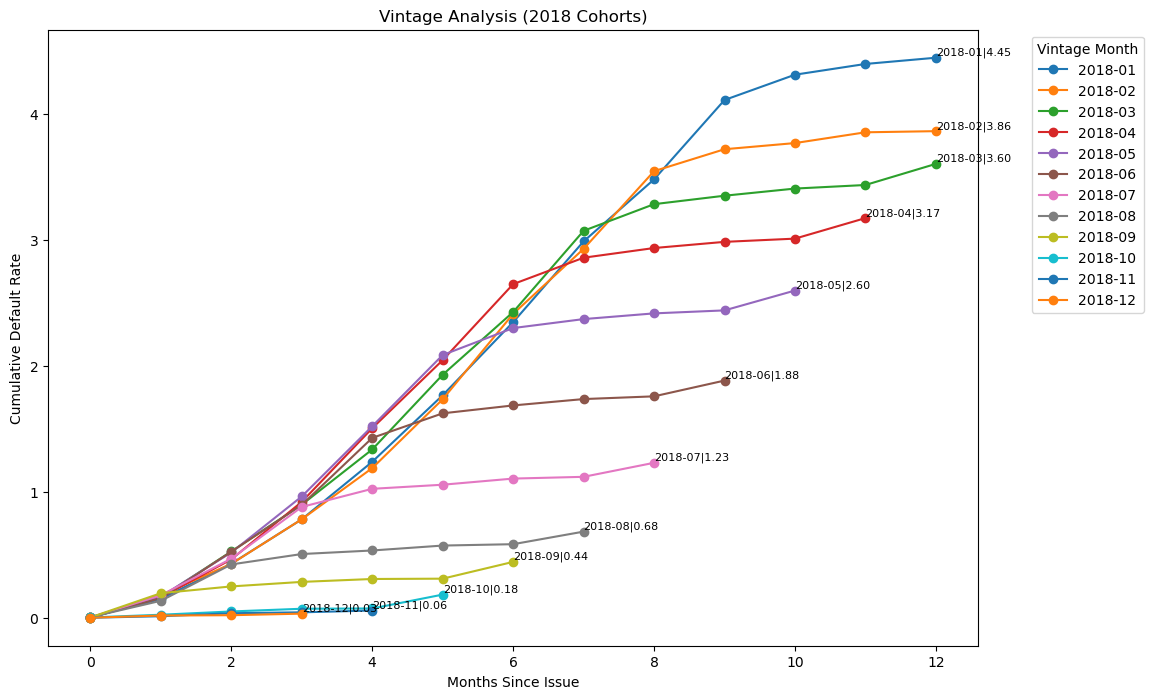

In [25]:
# Plotting the vintage analysis
plt.figure(figsize=(12, 8))
for i in vintage_analysis_2018.index:
    plt.plot(vintage_analysis_2018.columns, vintage_analysis_2018.loc[i], marker='o', label=str(i))
for i in vintage_analysis_2018.index:
    series = vintage_analysis_2018.loc[i]
    last_month = series.last_valid_index()
    last_value = series[last_month]
    plt.text(last_month, last_value, f"{i}|{last_value:.2f}", fontsize=8, ha='left', va='bottom')
plt.legend(vintage_analysis_2018.index.astype(str), title='Vintage Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Vintage Analysis (2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()

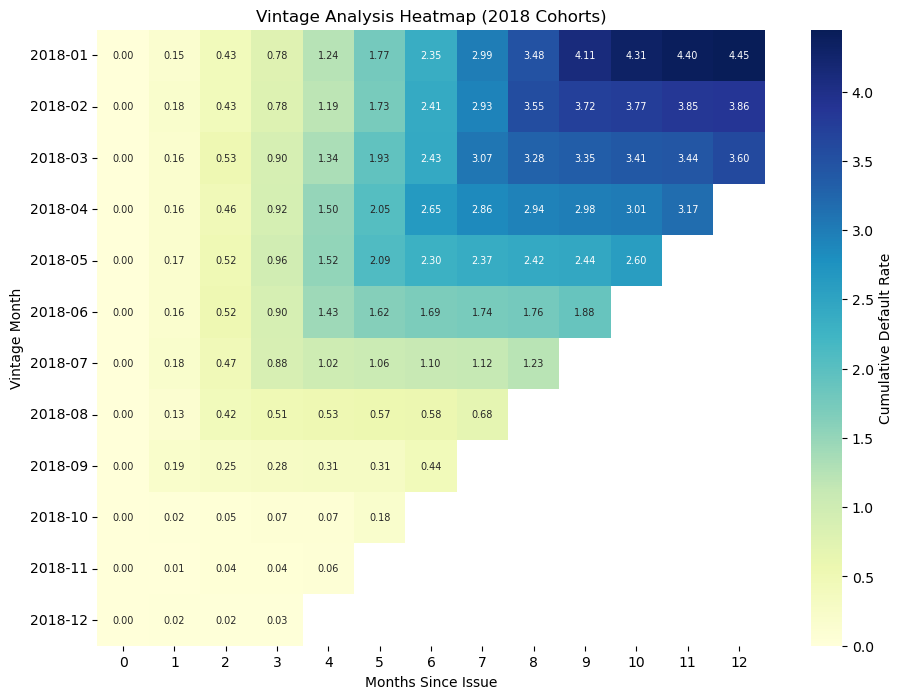

In [26]:
# Plotting the vintage analysis heatmap for 2018
plt.figure(figsize=(12, 8))
sns.heatmap(vintage_analysis_2018, square=True, annot=True, fmt=".2f", cmap="YlGnBu", annot_kws={"size": 7}, cbar_kws={'label': 'Cumulative Default Rate'})
plt.title('Vintage Analysis Heatmap (2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Vintage Month')
plt.show()

### Key Observations from 2018 Vintage Analysis Heatmap
- In early months of 2018, cumulative default rates rise sharply, reaching over 4% by month 12 for the January, February, and March cohorts. Indcating losser underwriting standards or economic challenges during that period.
- Middle of the year cohorts (April to August) show more moderate default rates, peaking around 2-3%. This suggests some improvement in loan performance as the year progressed.
- Later cohorts (September to December) have significantly lower default rates, staying below 1% in the first few months. This could be due to shorter observation periods or improved credit risk management.

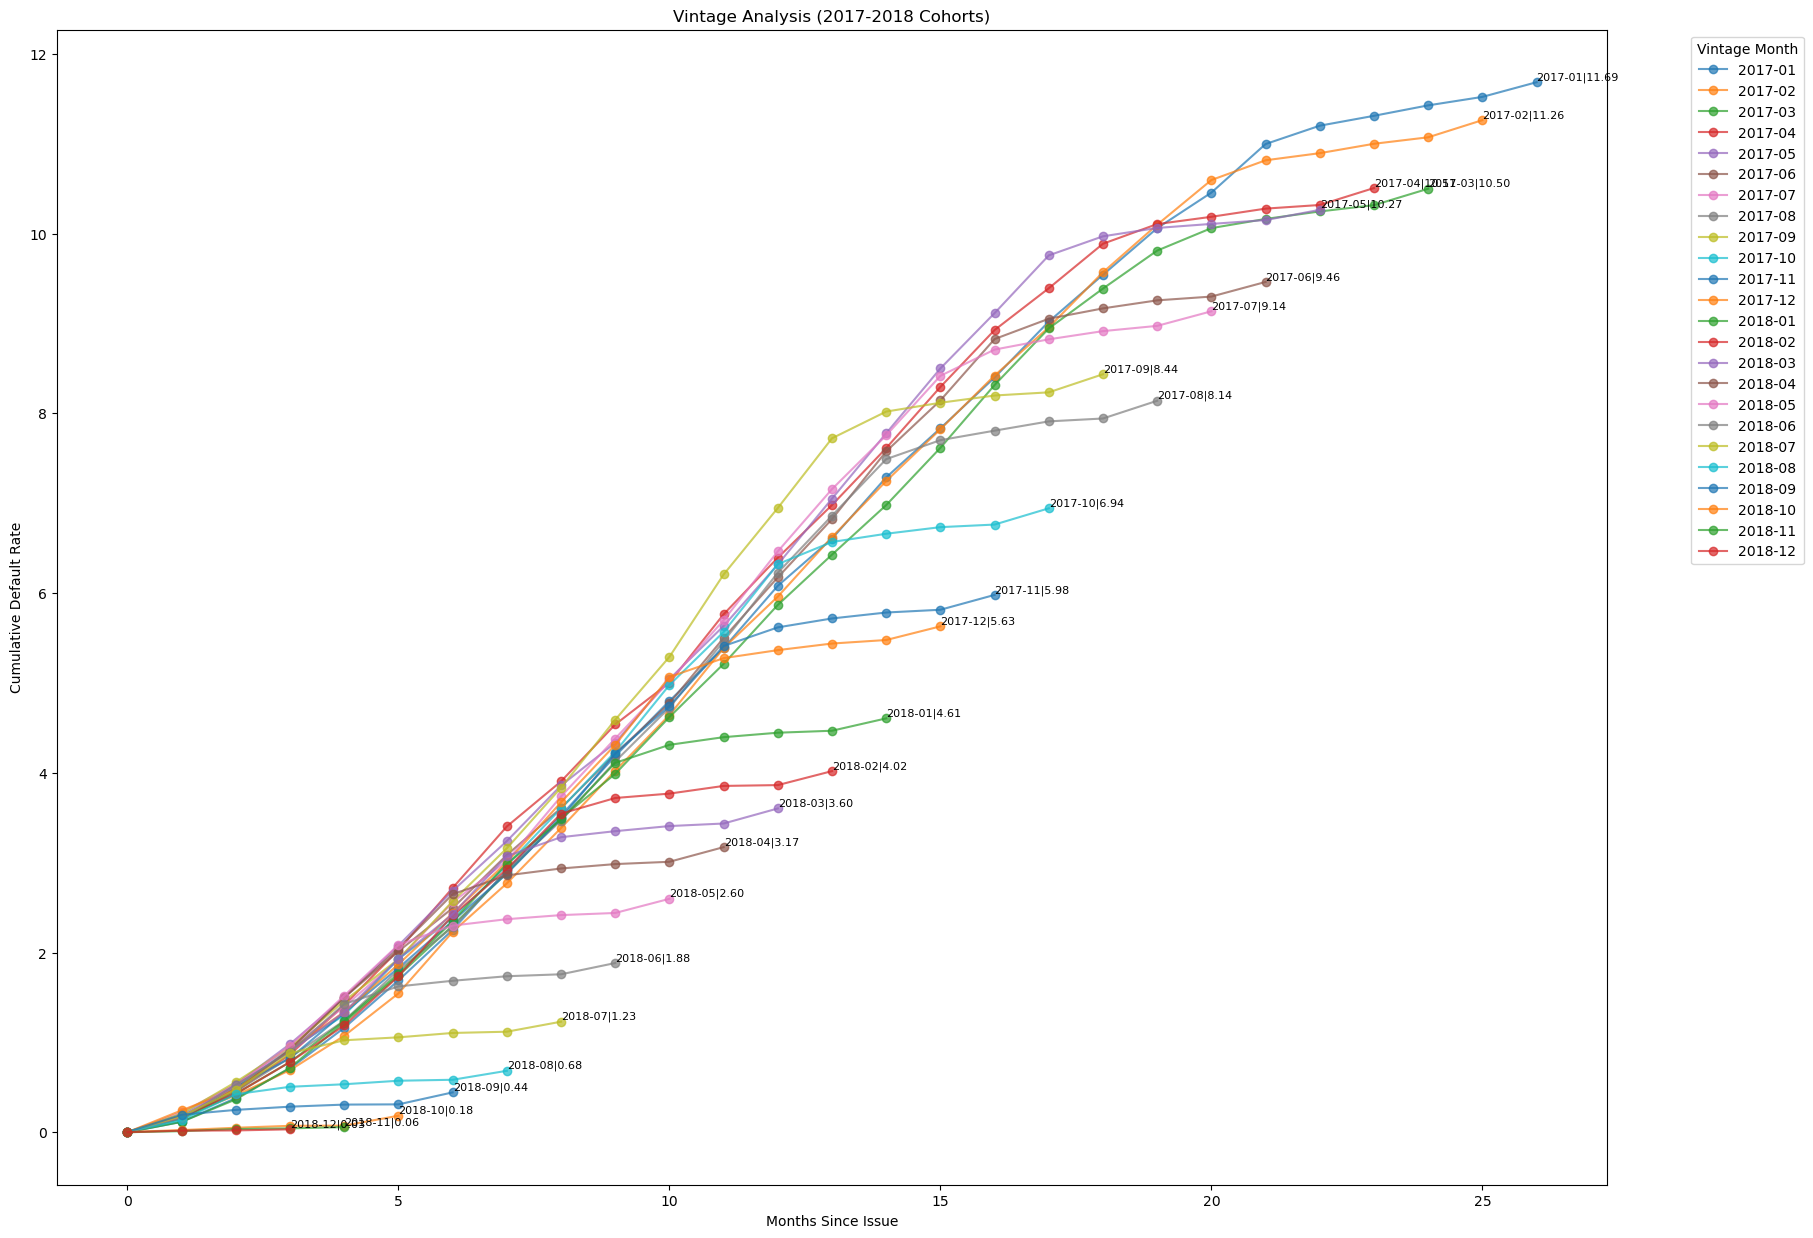

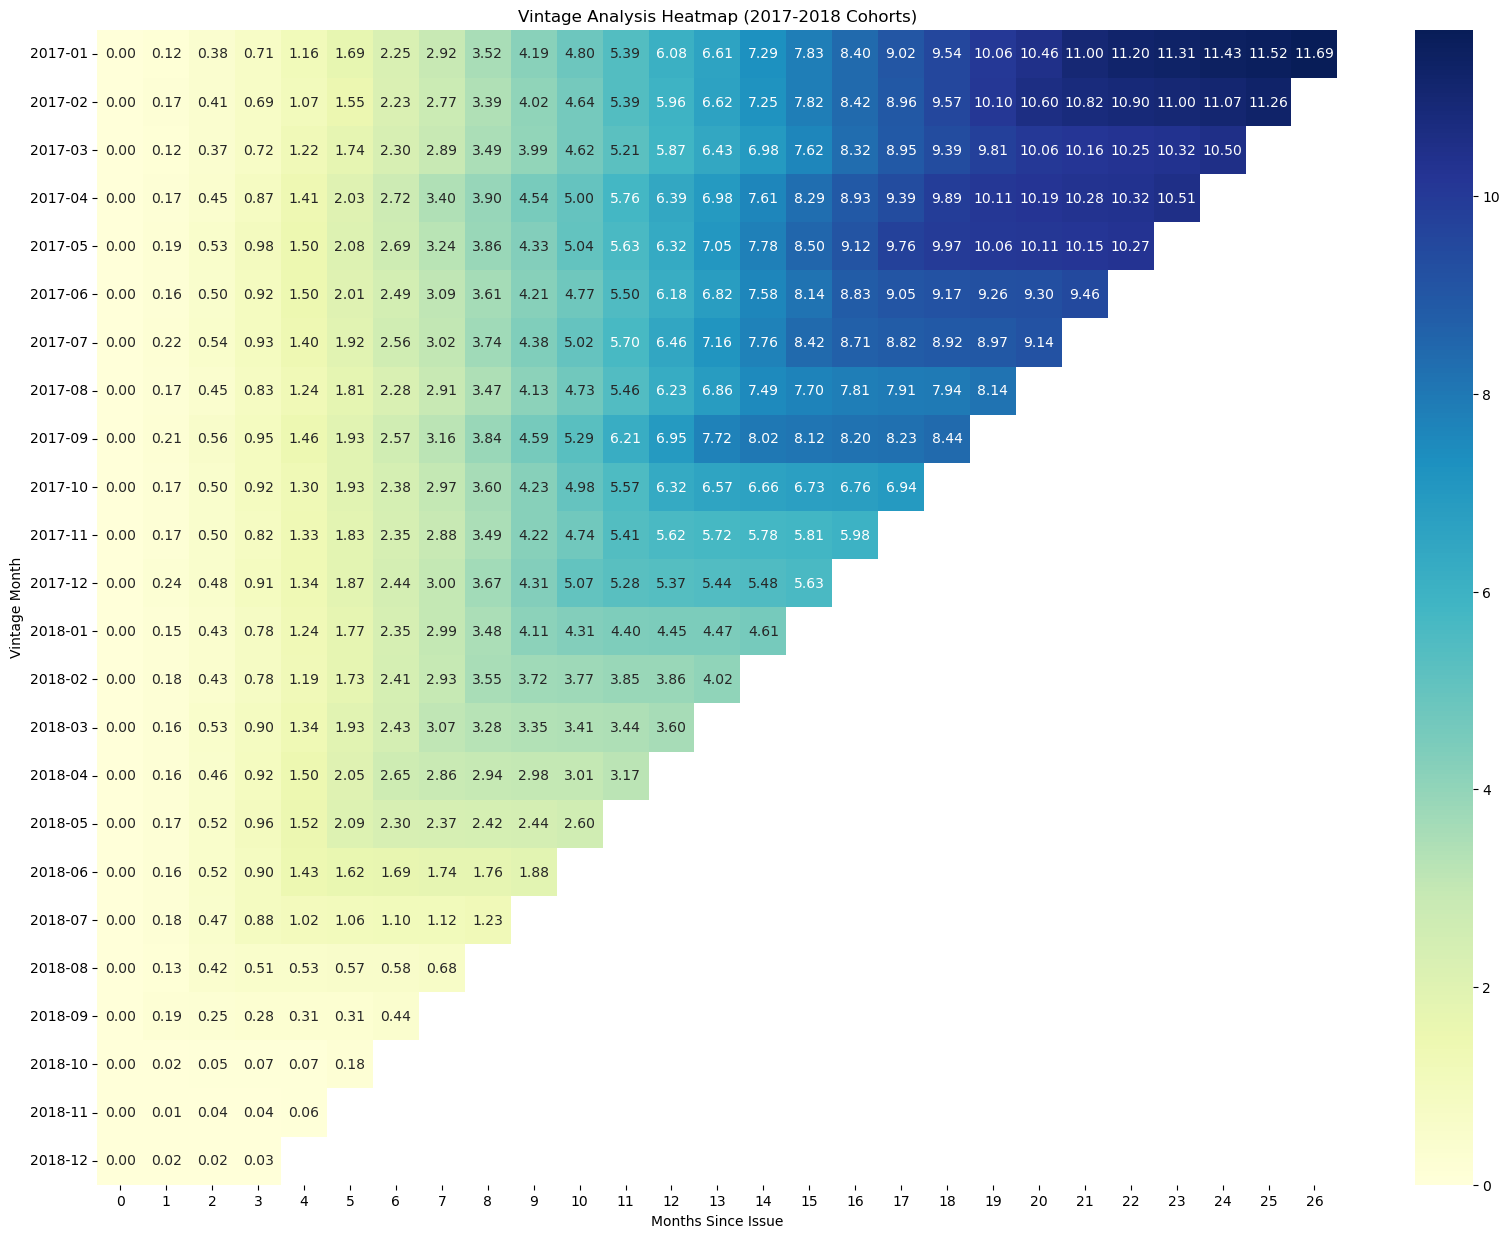

In [27]:
# Vintage analysis for 2017-2018
vintage_analysis_2017_2018 = cdr_masked.loc['2017-01':'2018-12', :]
vintage_analysis_2017_2018.dropna(axis=1, how='all', inplace=True)
vintage_analysis_2017_2018
# Plotting the vintage analysis for 2017-2018
plt.figure(figsize=(20, 15))
for idx in vintage_analysis_2017_2018.index:
    plt.plot(vintage_analysis_2017_2018.columns, vintage_analysis_2017_2018.loc[idx], marker='o', alpha=0.7)

for i in vintage_analysis_2017_2018.index:
    series = vintage_analysis_2017_2018.loc[i]
    last_month = series.last_valid_index()
    last_value = series[last_month]
    plt.text(last_month, last_value, f"{i}|{last_value:.2f}", fontsize=8, ha='left', va='bottom')

plt.legend(vintage_analysis_2017_2018.index.astype(str), title='Vintage Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Vintage Analysis (2017-2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()
# Plotting the vintage analysis heatmap for 2017-2018
plt.figure(figsize=(20, 15))
sns.heatmap(vintage_analysis_2017_2018, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Vintage Analysis Heatmap (2017-2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Vintage Month')
plt.show()

- In 2017, it was worse than 2018, with higher cumulative default rates (8-11%)
- Early 2018, imporved underwriting standards or economic conditions led to lower default rates compared to 2017.
- Mid 2018, underwriting strengthened further, resulting in even lower default rates, dropping to 1.5-2.5%
- Late 2018, strongest borrower profiles and tightened credit policies led to minimal defaults, with rates below 1%.

### Comparison Average CDR in 12 Months Across Years (2012-2018)

In [28]:
#Add cumulative default rates by year
vintage_cum_yearly = cdr_masked.resample('Y').last()
vintage_cum_yearly.index = vintage_cum_yearly.index.year
# Average cumulative default rates by year
vintage_cum_yearly.groupby(vintage_cum_yearly.index).mean()
# look at first 12 months of each year
vintage_cum_yearly_first12 = cdr_pct.groupby(cdr_pct.index.year).apply(lambda x: x.loc[:, 0:12].mean())
vintage_cum_yearly_first12

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12
vintage_month,,,,,,,,,,,,,
2007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.692419,2.117950,2.658491,3.789905,4.330446,4.330446
2008,0.000000,0.264033,0.416850,0.819356,1.194009,1.512277,2.019840,2.578781,3.067546,3.494375,4.671670,5.176030,5.804041
2009,0.000000,0.211476,0.494080,0.949064,1.574359,2.042250,2.411827,2.921909,3.427701,3.894605,4.279614,4.873083,5.223033
2010,0.000000,0.068734,0.287766,0.549733,0.860272,1.275749,1.611949,2.083979,2.499476,2.903136,3.387963,3.842653,4.256413
2011,0.000000,0.104008,0.389428,0.723312,1.133148,1.529757,1.999560,2.476750,2.934158,3.351951,3.898739,4.330887,4.817995
2012,0.000000,0.145522,0.416106,0.730033,1.173643,1.614047,2.072128,2.576151,3.135134,3.711956,4.287983,4.919236,5.485749
2013,0.000000,0.124033,0.320984,0.595957,0.909372,1.268809,1.669415,2.122888,2.611035,3.131541,3.631762,4.191992,4.721027
2014,0.000000,0.114556,0.312174,0.584094,0.923441,1.313985,1.794442,2.286714,2.797406,3.354741,3.923980,4.543265,5.133823
2015,0.000291,0.124102,0.349290,0.678889,1.068811,1.556040,2.083130,2.690844,3.325401,3.961761,4.649861,5.331309,6.020861


From 2007 to 2011, there have NaN values in month 0 and month 2 for 2007 vintage month, and month 0 from 2008 to 2011 vintage months. This is because Lending Club launched in mid-2007, so there were very few loans issued in 2007, and early data collection may have been inconsistent, very few loans issued in those initial months, leading to insufficient data to calculate default rates for those periods.

So we will focus on vintage months from 2012 onwards for more reliable analysis.

In [29]:
# From 2007 to 2011, there have NaN values in month 0 and month 2 for 2007 vintage month, and month 0 from 2008 to 2011 vintage months. 
vintage_cum_yearly_first12_from_2012 = vintage_cum_yearly_first12.loc[2012:]
vintage_cum_yearly_first12_from_2012

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12
vintage_month,,,,,,,,,,,,,
2012,0.000000,0.145522,0.416106,0.730033,1.173643,1.614047,2.072128,2.576151,3.135134,3.711956,4.287983,4.919236,5.485749
2013,0.000000,0.124033,0.320984,0.595957,0.909372,1.268809,1.669415,2.122888,2.611035,3.131541,3.631762,4.191992,4.721027
2014,0.000000,0.114556,0.312174,0.584094,0.923441,1.313985,1.794442,2.286714,2.797406,3.354741,3.923980,4.543265,5.133823
2015,0.000291,0.124102,0.349290,0.678889,1.068811,1.556040,2.083130,2.690844,3.325401,3.961761,4.649861,5.331309,6.020861
2016,0.000700,0.154578,0.436119,0.820571,1.292795,1.855457,2.493239,3.164267,3.877131,4.590061,5.304256,6.060332,6.783194
2017,0.000429,0.175742,0.472117,0.854482,1.328271,1.864734,2.438517,3.019721,3.631971,4.261962,4.891843,5.542549,6.145291
2018,0.001753,0.128167,0.344622,0.587982,0.853554,1.116351,1.352084,1.539348,1.670692,1.759779,1.800587,1.830773,1.849634


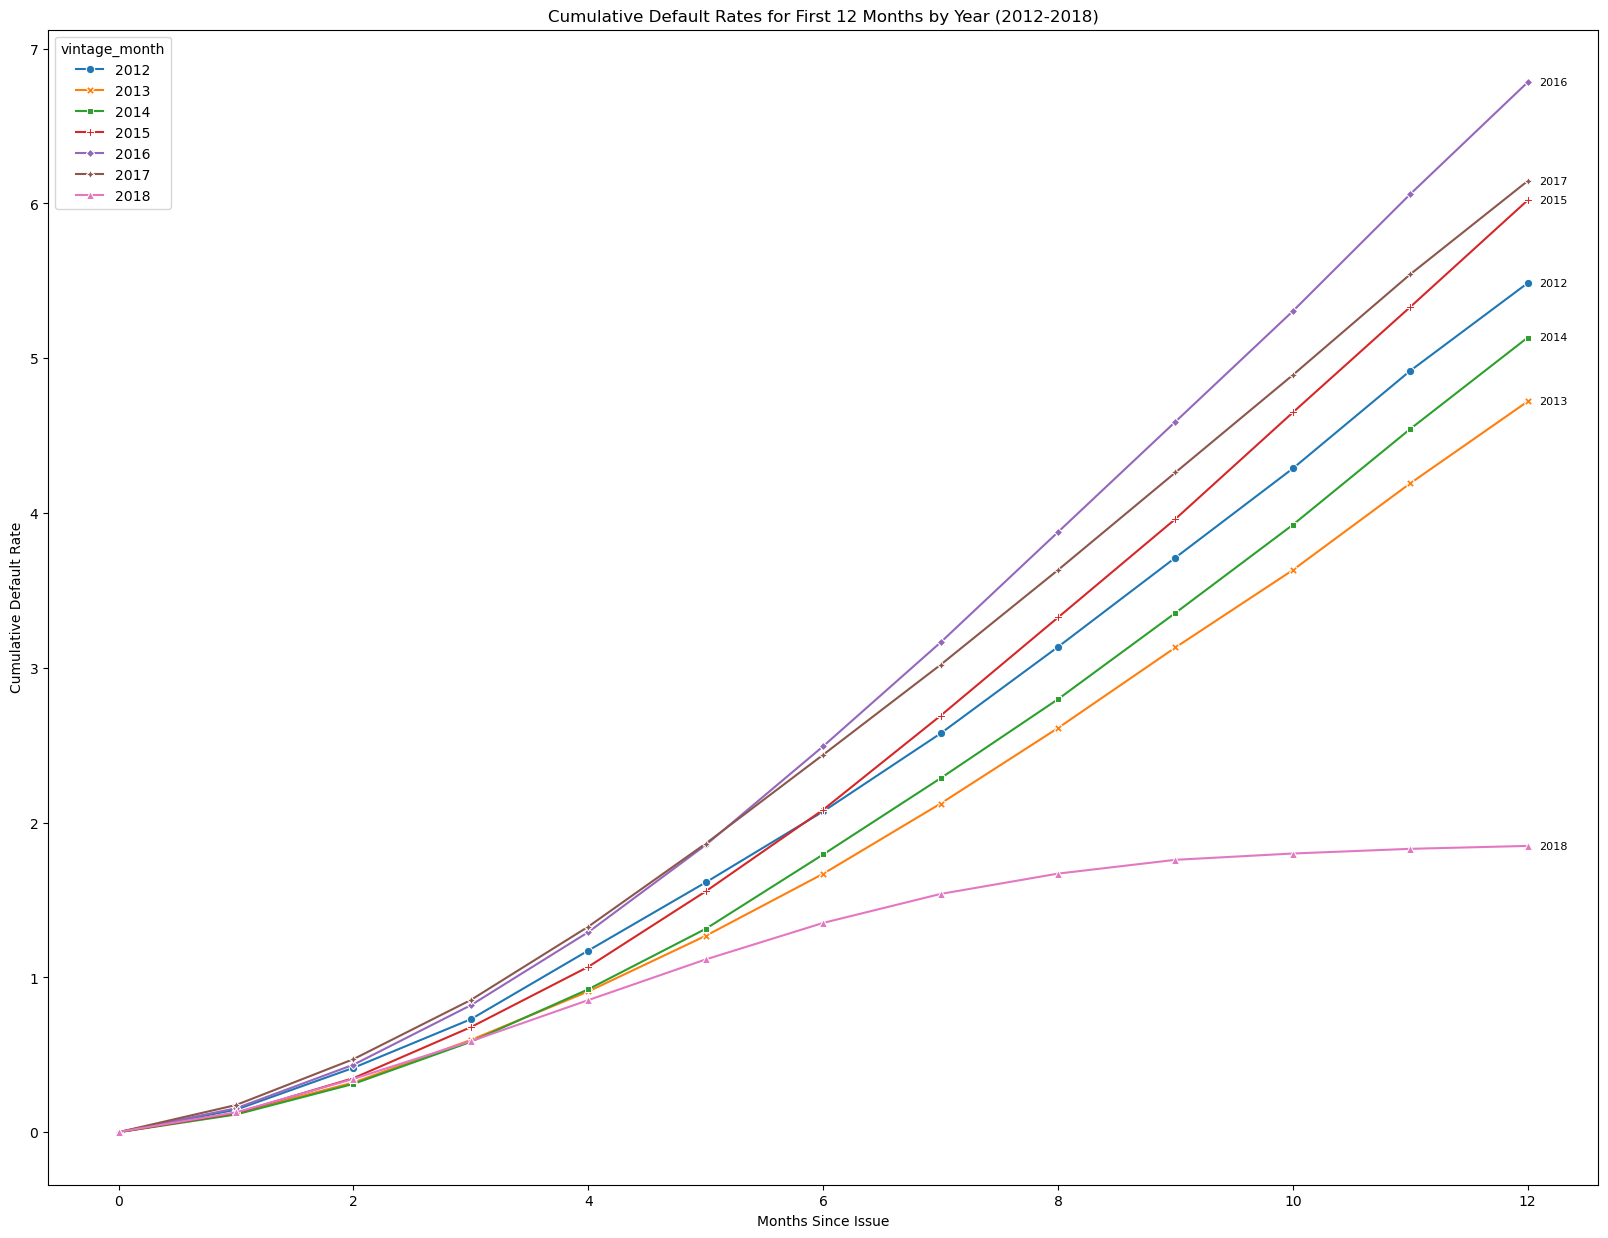

In [30]:
# Plotting the cumulative default rates for first 12 months by year from 2012
plt.figure(figsize=(20, 15))
sns.lineplot(data=vintage_cum_yearly_first12_from_2012.T, markers=True, dashes=False)
# Text notation at each line end year index
for year in vintage_cum_yearly_first12_from_2012.index:
    plt.text(12.1, vintage_cum_yearly_first12_from_2012.loc[year, 12], str(year), fontsize=8, verticalalignment='center')
plt.title('Cumulative Default Rates for First 12 Months by Year (2012-2018)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()

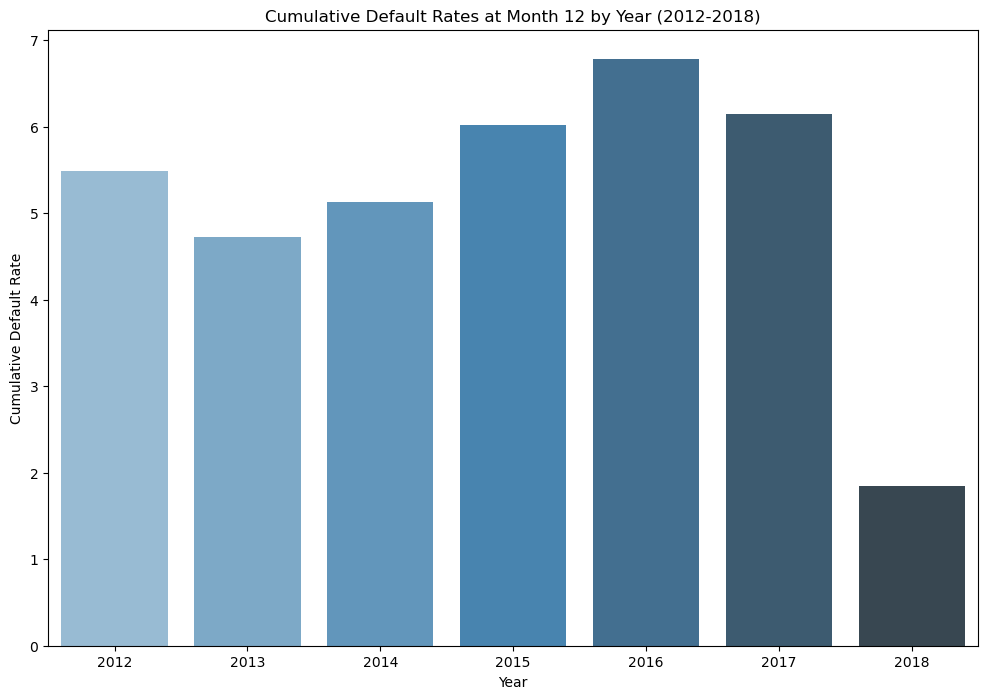

In [31]:
# Plot in month 12 cumulative default rates from 2012 onwards
plt.figure(figsize=(12, 8))
sns.barplot(x=vintage_cum_yearly_first12_from_2012.index, y=vintage_cum_yearly_first12_from_2012[12], palette="Blues_d")
plt.title('Cumulative Default Rates at Month 12 by Year (2012-2018)')
plt.xlabel('Year')
plt.ylabel('Cumulative Default Rate')
plt.show()

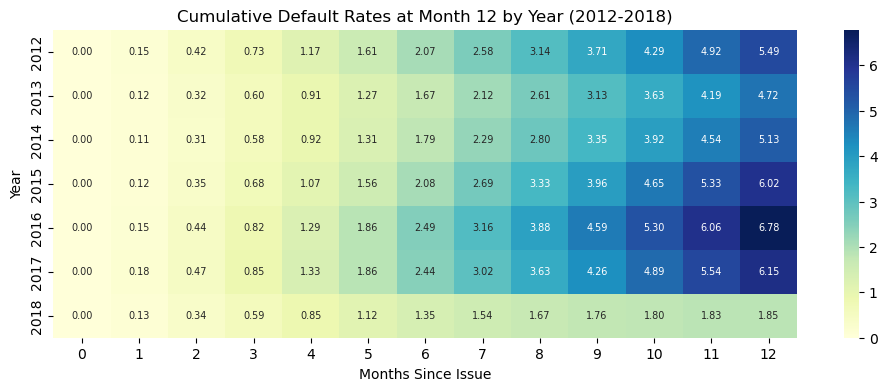

In [ ]:
# Heatmap of 12 months cumulative default rates from 2012 onwards
plt.figure(figsize=(12, 4))
sns.heatmap(vintage_cum_yearly_first12_from_2012, annot=True, fmt=".2f", cmap="YlGnBu", annot_kws={"size": 7})
plt.title('Average Cumulative Default Rates at Month 12 by Year (2012-2018)')
plt.xlabel('Months Since Issue')
plt.ylabel('Year')
plt.show()

- The graphs show that cumulative default rates at year 2016 and 2017 are significantly higher than other years, indicating that loans issued during these years had a higher risk of default within the first 12 months.
- Overall, vintage age of Lending Club loan originations from 2012 to 2018 shows a clear risk cyle. Default rose steadily from 2013 to peak in 2016, then declined through 2018, driven by economic conditions and underwriting changes. 2017 remained elevated before a sharp improvement in 2018. In 2018, vintage cohorts exhihited the lowest cumulative default rates in early months, reflecting stronger credit quality and risk management practices.

### Comparison of Cumulative Default Rates at Month 12 and Month 36

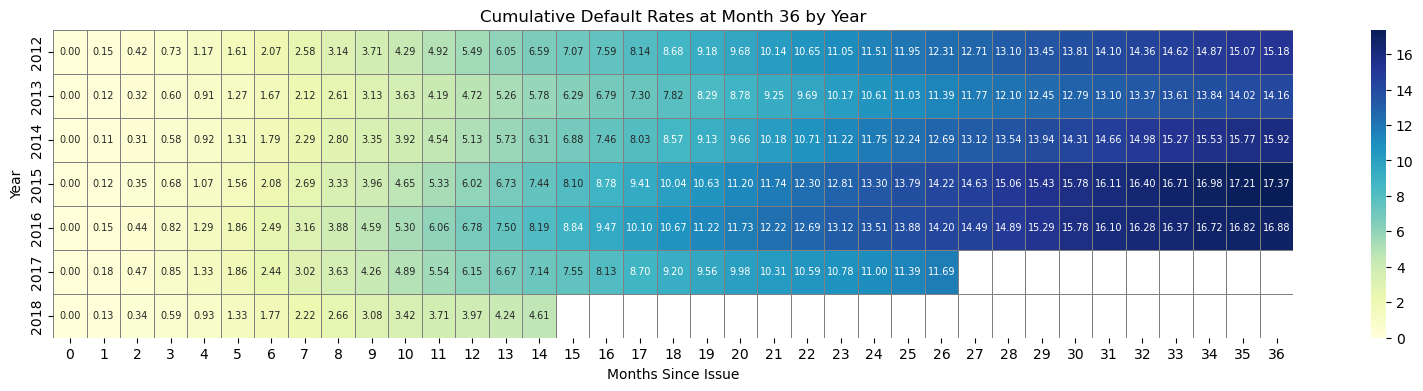

In [33]:
# month-36 and 60 of each year
vintage_cum_yearly_36 = cdr_masked.groupby(cdr_masked.index.year).apply(lambda x: x.loc[:, :36].mean())
vintage_cum_yearly_36_from_2012 = vintage_cum_yearly_36.loc[2012:]
# Heatmap of 36 months cumulative default rates from 2012 onwards
plt.figure(figsize=(20, 4))
sns.heatmap(vintage_cum_yearly_36_from_2012, annot=True, fmt=".2f", annot_kws={"size": 7}, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title('Cumulative Default Rates at Month 36 by Year')
plt.xlabel('Months Since Issue')
plt.ylabel('Year')
plt.show()

- Default rate at month 36 rises significantly between 2013 and peak in 2016 and 2017, indicating higher long-term credit risk for loans issued during these years. The worst vintages are 2016 and 2017, with cumulative default rates exceeding 16-17% by month 36.
- Post-2017 vintages show marked improvement, with 2018 cohorts exhibiting the lowest long-term default rates, 4% by month 12, and 4.6% by month 14. This reflects enhanced underwriting standards and risk management practices implemented by Lending Club during this period.

### Conclusions
- The vintage analysis provides insights into how default rates evolve over time for different cohorts of loans, which is valuable for credit risk modeling and understanding loan performance trends.
- From 2011 to 2018, the cumulative default rates for loans issued in each month show a general trend of decreasing default rates. This indicates that Lending Club's loan portfolio has improved in quality over time, likely due to better underwriting practices, risk assessment.
- In 2018, the cumulative default rates are significantly lower compared to previous years. For example the average loans issued in 2012 had a cumulative default rate of about 6% after 12 months, while loans issued in 2018 had a cumulative default rate of approximately 2% after the same period. This suggests that Lending Club has been successful in reducing credit risk in its loan portfolio over the years.